## Self-play
Following notebook will show you how to train agent to learn play in our [game](../../environment.rst) by sefl-play using our [API](../../api/index.rst)
. This notebook is easier to understand if you has already read about our [game](../../environment.rst).  

In this example, we will train an agent to control robot on the board with 3 robots and battery isn't considered.

### Install our library.

In [6]:
%pip install -q rbgame

In [ ]:
import os
import time
import math
from pprint import pprint
from typing import Any

import numpy as np
import yaml
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
from torch import nn, optim
import pygame
from tianshou.utils.net.common import Net
from tianshou.policy import DQNPolicy, C51Policy
from tianshou.data import PrioritizedVectorReplayBuffer
from rbgame.trainer import DecentralizedTrainer
from rbgame.agent.rl_agent import OffPolicyAgent

### Create the neural network and policy.
Simply, policy is neural network with 2 main methods:

* `forward()`, what shows how policy can provide action based on the input observation.
* `update()`, what shows how policy can update its networks.

For policies implementions, we use friendly and easy customizable library tianshou. Visit [their documentation](https://tianshou.org/en/stable/index.html) for more details.

Because our action space is discrete, the most efficient and suitable simple algorithm recommended is [DQN](https://arxiv.org/pdf/1312.5602).

For now, we're using decentralized method which mean each agent controls one robots and they only learns to optimize its own reward, they're not concerned about what other do. Therefore, in training phase, we train agents independently and in test phase, they can play together as one team. For example, we train 8 robots and after that, we let 4 robots play in one team. 

Because observation from our environment is feature vector of all robots so we don't need complicate CNN or RNN to extract features. We need only simple multi-layer perceptron.

In [18]:
# see about Net object in https://tianshou.org/en/stable/03_api/utils/net/common.html#tianshou.utils.net.common.Net
net = Net(
    # state_shape is obsevation vector shape,
    # every robot have 3 features (x, y, mail_index) and we have 3 robots on the board
    state_shape=3*3,
    # 5 actions are possible
    action_shape=5,
    # network hidden layer sizes
    hidden_sizes=[1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64],
    # LayerNorm for avoid vanishing and exploding gradients
    norm_layer=nn.LayerNorm,
    # GPU divice
    device='cuda',
    # dueling part of network, see https://arxiv.org/pdf/1511.06581
    dueling_param=[{'hidden_sizes':[32], 'norm_layer':nn.LayerNorm},
                   {'hidden_sizes':[32], 'norm_layer':nn.LayerNorm}],
)
# see about DQNPolicy in https://tianshou.org/en/stable/03_api/policy/modelfree/dqn.html#tianshou.policy.modelfree.dqn.DQNPolicy
policy = DQNPolicy(
    model=net,
    # Adam optim with learning rate = 0.0001
    optim=optim.Adam(net.parameters(), lr=0.0001),
    # discrete action space with 5 possible actions
    action_space=gym.spaces.Discrete(5),
    # discount_factor \gamma
    discount_factor=0.99,
    # multi-step return n, see https://arxiv.org/pdf/1509.06461
    estimation_step=30,
    # frequency for target network updating
    target_update_freq=500,
    # Double DQN, see https://arxiv.org/pdf/1509.06461
    is_double=True,
)

Let see our network architure.

In [19]:
net

Net(
  (model): MLP(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (8): ReLU()
      (9): Linear(in_features=512, out_features=512, bias=True)
      (10): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=256, bias=True)
      (13): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (14): ReLU()
      (15): Linear(in_features=256, out_features=256, bias=True)
      (16): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (17): ReLU()
      (18): Linear(in_features=256, out_features=128, bias=T

### Create memory.
We'll use [Prioritized Replay Buffer](https://arxiv.org/pdf/1511.05952). To accelerate training, we'll use two stuffs:

* First, agent parallel plays in many environments (neural network can feed forward batch of observations from many environments, its faster than feed each one through).
* Second, agent not only save its own transitions, but also transitions of other agents.

So we need to save transitions correctly in memory. That mean transitions for one agent and one environment need to be saved exactly in one replay buffer.

In [20]:
# see about PrioritizedVectorReplayBuffer in 
# https://tianshou.org/en/stable/03_api/data/buffer/vecbuf.html#tianshou.data.buffer.vecbuf.PrioritizedVectorReplayBuffer
memory = PrioritizedVectorReplayBuffer(
    # total size of memory is product of maximum number parallel environments steps and number episodes
    # to train, so memory can storage all excuted transitions during training
    total_size=500*5000,
    # agent save not only its transitions but also transitions of other agents so
    # number buffers is product of number parallel environments and numbers robots
    buffer_num=3*16,
    # prioritization exponent \alpha
    alpha=0.6,
    # prioritization importance sampling \beta
    beta=0.4,
)

### Create agent.
DQN is off-policy algorithm so we use [OffPolicyAgent](../../api/agent/rl_agent.rst).

We're using self-play, which mean one agent'll play as all players, it controls one robot in current turn and continues to control other in next turn. So all elements in `agents` list point to one unique [OffPolicyAgent](../../api/agent/rl_agent.rst) object.

In [21]:
agent = OffPolicyAgent(
    policy=policy,
    memory=memory,
    # how many times agent samples from memory and learns per one step, using only in offpolicy algorithms.
    update_per_step=0.02,
)
agents = [agent]*3

### Create trainer.
First, we need to adjust some hyperparameters during training. They're exploration coefficient ϵ, which decides how agent explores during training, and prioritization importance sampling β of Prioritized Replay Buffer.

In this example, we'll let α decreases from 1.0 → 0.05 along 5000 episodes of traning by following function:
$$ϵ = max(b*f^n, e)$$
where $b=1.0$ - begin value, $f = 0.9995$ - decay factor, $e = 0.05$ - end value, and $n$ - number collected episodes.

And the β is adjusted from 0.4 → 1.0 according to recommendation from [original paper](https://arxiv.org/pdf/1511.05952):
$$\beta = e + (b-e)*e^{-rn}$$
where $b=0.4$ - begin value, $r = 0.002$ - decay rate, $e = 1.0$ - end value, and $n$ - number collected episodes.

In [2]:
def exponential_annealing(begin, end, decay_factor):
    return lambda episode: max(begin*decay_factor**episode, end)

def natural_exponential_annealing(begin, end, rate):
    return lambda episode: end + (begin - end) * math.exp(-rate * episode)

def cosine_annealing(begin, end, steps):
    return lambda x: max((1 - math.cos(x * math.pi / steps)) / 2, 0) * (end - begin) + begin if x <= steps else end

Let see graphics of these functions.

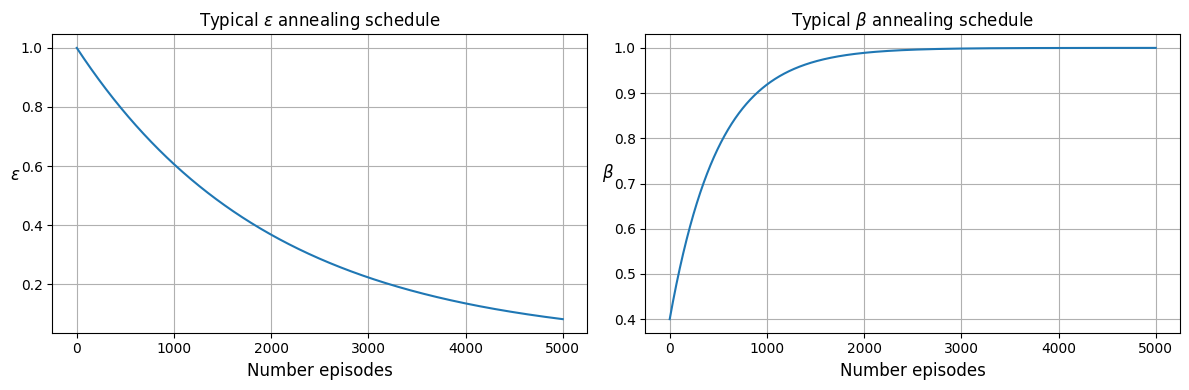

In [5]:
# A scheduler to adjust exploration coefficient \epsilon during training
eps_schedule = exponential_annealing(1.0, 0.05, 0.9995)
# A scheduler to adjust prioritization importance sampling \beta during training
beta_schedule = natural_exponential_annealing(0.4, 1.0, 0.002)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot([eps_schedule(ep)for ep in range(5_000)])
axes[0].set_ylabel(r"$\epsilon$", rotation="horizontal", fontsize=12)
axes[0].set_xlabel("Number episodes", fontsize=12)
axes[0].set_title(r"Typical $\epsilon$ annealing schedule", fontsize=12)
axes[0].grid()
axes[1].plot([beta_schedule(ep)for ep in range(5_000)])
axes[1].set_ylabel(r"$\beta$", rotation="horizontal", fontsize=12)
axes[1].set_xlabel("Number episodes", fontsize=12)
axes[1].set_title(r"Typical $\beta$ annealing schedule", fontsize=12)
axes[1].grid()
fig.tight_layout()
plt.show()

Next, we must to define some functions to specify what we do during training like adjusting hyperparameters and saving checkpoints. 

In [22]:
FOLDER = 'DQNagent'
os.makedirs(os.path.join(os.getcwd(), FOLDER), exist_ok=True)
# best model checkpoint
best_ckpt=os.path.join(FOLDER, 'best.pth')
# last model checkpoint
last_ckpt=os.path.join(FOLDER, 'last.pth')
# optimizer checkpoint
optim_ckpt=os.path.join(FOLDER, 'optim.pth')
# policy config checkpoint
policy_ckpt=os.path.join(FOLDER, 'policy.yaml')
# detect model with best metric only begins after that episode
episode_to_save=1000

# called after a few episodes to change \epsilon and \beta
def train_fn(episode: int, step: int) -> None:
    agent.policy.set_eps(eps_schedule(episode))
    agent.memory.set_beta(beta_schedule(episode))

# called when detect better metric
def save_best_fn(episode: int) -> None:
    if episode > episode_to_save:
        torch.save(agent.policy.state_dict(), best_ckpt)

# called when training is finished
def save_last_fn() -> None:
    torch.save(agent.policy.state_dict(), last_ckpt)
    torch.save(agent.policy.optim.state_dict() , optim_ckpt)
    policy_state = {}
    policy_state['type'] = agent.policy.__class__.__module__+"."+agent.policy.__class__.__name__
    policy_state['model'] = dict(
        type=agent.policy.model.__class__.__module__+"."+agent.policy.model.__class__.__name__,
        state_shape=3*3,
        action_shape=5,
        hidden_sizes=[1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64],
        norm_layer=nn.LayerNorm.__module__+'.'+nn.LayerNorm.__name__,
        device='cuda',
        dueling_param=[{'hidden_sizes':[32], 'norm_layer':nn.LayerNorm.__module__+'.'+nn.LayerNorm.__name__},
                        {'hidden_sizes':[32], 'norm_layer':nn.LayerNorm.__module__+'.'+nn.LayerNorm.__name__}],
    )
    policy_state['optim'] = dict(
        type=agent.policy.optim.__class__.__module__+"."+agent.policy.optim.__class__.__name__,
    )
    policy_state['action_space'] = dict(
        type=agent.policy.action_space.__class__.__module__+"."+agent.policy.action_space.__class__.__name__,
        n=5,
    )
    policy_state.update(dict(
        discount_factor=0.99,
        estimation_step=30,
        target_update_freq=500,
        is_double=True,
    ))
    with open(policy_ckpt, 'w') as file:
        yaml.dump(policy_state, file, default_flow_style=False, sort_keys=False)

In [25]:
# copy layout .csv file from our package to initalize environment
%cp -r /usr/local/lib/python3.10/dist-packages/rbgame/assets .

Now, we ready to create a [DecentralizedTrainer](../../api/trainer.rst).

In [31]:
trainer = DecentralizedTrainer(
    # environment arguments
    env_args = dict(
        colors_map='assets/csv_files/colors_map.csv',
        targets_map='assets/csv_files/targets_map.csv',
        # 5 mails to win
        required_mail=5,
        # 3 players
        robot_colors=['r', 'b', 'gr'],
        # 1 robot for each players
        num_robots_per_player=1,
        # battery isn't considered
        with_battery=False,
        # one step per turn
        random_num_steps=False,
        # maximum environment step
        max_step=600,
    ),
    # number parallel environments to train
    num_train_envs=16,
    # number parallel environments to test
    num_test_envs=16,
    batch_size=64,
    # after how many step update network
    update_freq=200,
    # after how many episodesdo a test
    test_freq=100,
    # number episodes to train
    episodes_per_train=5_000,
    # number episodes per test
    episodes_per_test=48,
    train_fn=train_fn,
    save_best_fn=save_best_fn,
    save_last_fn=save_last_fn,
)

### Start training.

In [ ]:
agent.policy.to('cuda')

In [ ]:
# def move_optimizer_to_device(optimizer, device):
#     for state in optimizer.state.values():
#         for k, v in state.items():
#             if isinstance(v, torch.Tensor):
#                 state[k] = v.to(device)
# move_optimizer_to_device(agent.policy.optim, 'cuda')

===episode 0112 done with number steps: 247.2, reward: +13.67===
===episode 0224 done with number steps: 236.5, reward: +14.46===
===episode 0336 done with number steps: 225.3, reward: +14.79===
===episode 0448 done with number steps: 208.1, reward: +18.06===
===episode 0560 done with number steps: 208.6, reward: +17.36===
===episode 0672 done with number steps: 419.4, reward: +01.80===
===episode 0784 done with number steps: 199.7, reward: +18.81===
===episode 0896 done with number steps: 215.3, reward: +18.76===
===episode 1008 done with number steps: 198.0, reward: +19.55===
===episode 1120 done with number steps: 187.5, reward: +19.88===
===episode 1232 done with number steps: 188.7, reward: +18.89===
===episode 1344 done with number steps: 261.1, reward: +15.00===
===episode 1456 done with number steps: 181.5, reward: +19.38===
===episode 1568 done with number steps: 195.6, reward: +19.35===
===episode 1680 done with number steps: 249.7, reward: +15.96===
===episode 1792 done with

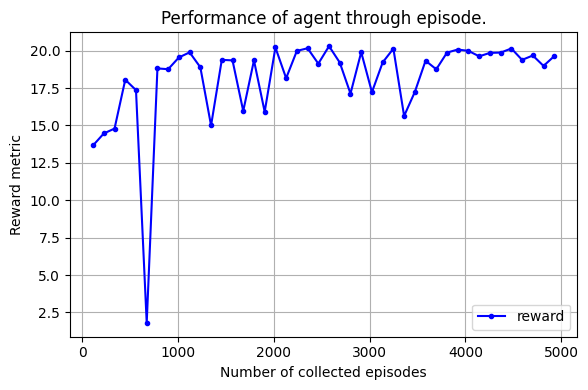

In [33]:
train_stat = trainer.train(
    # self-play, all elements in agents list point to one unique OffPolicyAgent object.
    agents, 
    # Only the first agent learns, the other agents are the same agent.
    [i == 0 for i,_ in enumerate(agents)]
)

In [35]:
train_stat.pop('reward_metric_stats')
pprint(train_stat)

{'num_collected_episodes': 5008,
 'num_collected_steps': 1553841,
 'num_gradient_steps': 29952,
 'training_time': 990.6171650886536}


Training takes about 15 minutes on Colab GPU.

### Evaluation.
Let see how agent perform in environment with bigger required number mails.

In [39]:
tester = DecentralizedTrainer(
    env_args = dict(
        colors_map='assets/csv_files/colors_map.csv',
        targets_map='assets/csv_files/targets_map.csv',
        required_mail=15,
        robot_colors=['r', 'b', 'gr'],
        num_robots_per_player=1,
        with_battery=False,
        random_num_steps=False,
        max_step=2000,
    ),
    num_test_envs=16,
    episodes_per_test=48,
)

In [37]:
# load best model to perform
agent.policy.load_state_dict(torch.load(f=best_ckpt, weights_only=True, map_location=torch.device(agent.policy.model.device)))

<All keys matched successfully>

In [41]:
pprint(tester.test(agents, True))

{'count_wins': {'b': 17, 'gr': 13, 'r': 18},
 'mean_num_steps': 579.6458333333334,
 'num_collected_episodes': 48,
 'num_collected_steps': 27823,
 'reward': 65.62430555555545,
 'time_spans': 572.7916666666666}


The game process statistics can be evaluated by method `DecentralizedTrainer.test(agents, eval_metrics=True)`. It show you average time span of the game process in `'time_spans'` key and number of wins for each player across all episodes of test in `'count_wins'` key. It seem like we have balance game when all players have almost the same number of wins.

Our trained model work well, no game is ended without winner. But because it's example so we have small number robots on the board. For more robots and robot moves with battery, which mean larger observation space and agent also have to learn to charge the battery when it is low, we need longer training and tuning hyperparameters.